Info

In [34]:
#Name of the Project: Real or Not? NLP with Disaster Tweets
#Data extracted from:https://www.kaggle.com/c/nlp-getting-started
#With this model we want to deploy a nlp text classifier model using tensor flow 
#I worked(github.com/albertodiaz-dev) in this project together with the help of (github.com/NMedinaV)

Intro 


In [35]:
#Twitter has become an important communication channel in times of emergency.
#The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. 
#Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

In [2]:
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.layers import Dropout

In [3]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")
print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


In [4]:
#check nulls in df_train
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
#check nulls in df_test
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [6]:
#Drop column location in test and train and also drop na 
df_train = df_train.drop('location', axis=1)
df_test = df_test.drop('location', axis=1)
df_train = df_train.dropna()
df_test = df_test.dropna()

In [7]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
#Cleaning the tweet
def cleanTweet(review_text):
    review_text = re.sub(r'http\S+', '', review_text)
    review_text = re.sub('[^a-zA-Z]', ' ', review_text)
    review_text = str(review_text).lower()
    review_text = word_tokenize(review_text)
    review_text = [item for item in review_text if item not in stop_words]
    review_text = [lemma.lemmatize(word=w,pos='v') for w in review_text]
    review_text = [i for i in review_text if len(i)>2]
    review_text = ' '.join(review_text)
    return review_text

df_train['cleanTweet'] = df_train['text'].apply(cleanTweet)
df_test['cleanTweet'] = df_test['text'].apply(cleanTweet) 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
df_test

,id,keyword,text,cleanTweet
15,46,ablaze,Birmingham Wholesale Market is ablaze BBC News...,birmingham wholesale market ablaze bbc news fi...
16,47,ablaze,@sunkxssedharry will you wear shorts for race ...,sunkxssedharry wear short race ablaze
17,51,ablaze,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,previouslyondoyintv toke makinwa marriage cris...
18,58,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...,check nsfw
19,60,ablaze,PSA: IÛªm splitting my personalities.\n\n?? t...,psa split personalities techies follow ablaze ...
...,...,...,...,...
3247,10806,wrecked,RT CNBC '3 words from Disney CEO Bob Iger wrec...,cnbc word disney ceo bob iger wreck disney sto...
3248,10807,wrecked,Smackdown tyme this should put me in a good mo...,smackdown tyme put good mood since get wreck smh
3249,10816,wrecked,@thrillhho jsyk I haven't stopped thinking abt...,thrillhho jsyk stop think abt remus slump bath...
3250,10820,wrecked,@stighefootball Begovic has been garbage. He g...,stighefootball begovic garbage get wreck red b...


In [9]:
# Create a function that counts words
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [10]:
frases_train = df_train.cleanTweet
oov_tok = "<XXX>"
counter_train = counter_word(frases_train)
vocab_size_train = len(counter_train)
#(tokenizer)turn each text into either a sequence of integers or into a vector where the coefficient for each token could be binary
tokenizer = Tokenizer(num_words=vocab_size_train, oov_token=oov_tok)
#(fit_on_texts)Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. 
tokenizer.fit_on_texts(frases_train) 
#(word_index)A dictionary of words and their uniquely assigned integers.
word_index = tokenizer.word_index

In [11]:
# Word_count
maxs1 = (df_train['cleanTweet'].apply(lambda x: len(str(x).split()))).max()
maxs2 = (df_test['cleanTweet'].apply(lambda x: len(str(x).split()))).max()
max_length = maxs1-1
padding_type='post'
trunc_type='post'

training_size = 6090

training_sentences = df_train.cleanTweet[0:training_size]
training_labels = df_train.target[0:training_size]

testing_sentences = df_train.text[training_size:]
testing_labels = df_train.target[training_size:]



#(texts_to_sequences)Transforms each text in texts to a sequence of integers. 
#So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.

#(pad_sequences) is used to provide uniformity in the sentences.

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(df_train['cleanTweet'][0:1].values)
print(training_sequences[1])

['bbcmtd wholesale market ablaze']
[230, 137, 295, 677, 990]


In [12]:
X = training_padded
y = training_labels

In [28]:
#Create train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# For a binary classification problem
embedding_dim=32

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size_train, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    #32 is the number of outputs that is desired from that layer.The LSTM layer in a bidirectional format, means that goes in both directions.
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



**RRNN**

In [29]:
history = model.fit(X_train, y_train, epochs=10, verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
128/128 [==============================] - 3s 25ms/step - loss: 0.6587 - accuracy: 0.6078 - val_loss: 0.5434 - val_accuracy: 0.7721
Epoch 2/10
128/128 [==============================] - 2s 18ms/step - loss: 0.4087 - accuracy: 0.8390 - val_loss: 0.4880 - val_accuracy: 0.7881
Epoch 3/10
128/128 [==============================] - 2s 19ms/step - loss: 0.2383 - accuracy: 0.9218 - val_loss: 0.6224 - val_accuracy: 0.7692
Epoch 4/10
128/128 [==============================] - 3s 20ms/step - loss: 0.1442 - accuracy: 0.9547 - val_loss: 0.7048 - val_accuracy: 0.7527
Epoch 5/10
128/128 [==============================] - 3s 20ms/step - loss: 0.1110 - accuracy: 0.9664 - val_loss: 0.7582 - val_accuracy: 0.7507
Epoch 6/10
128/128 [==============================] - 2s 18ms/step - loss: 0.0854 - accuracy: 0.9743 - val_loss: 0.9446 - val_accuracy: 0.7433
Epoch 7/10
128/128 [==============================] - 2s 19ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 1.3455 - val_accuracy: 0.7597

In [30]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.658720,0.607843,0.543427,0.772139
1,0.408689,0.838971,0.487995,0.788060
2,0.238283,0.921814,0.622364,0.769154
3,0.144231,0.954657,0.704812,0.752736
4,0.110957,0.966422,0.758177,0.750746


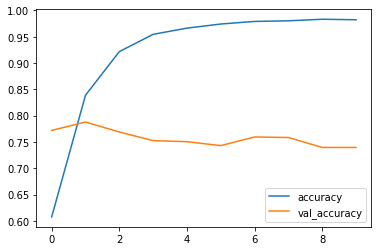

In [31]:
model_loss[['accuracy','val_accuracy']].plot();

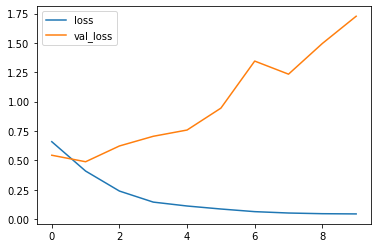

In [32]:
model_loss[['loss','val_loss']].plot();